In [162]:
# %pip install langchain==0.3.7 langchain-community==0.3.7 langchain_google_genai==2.0.4 duckduckgo_search==6.3.4 langgraph==0.2.48 -q

In [190]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["Tavily_API_KEY"] = os.getenv("Tavily_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             verbose=True,
                             temperature=0.5,
                             api_key=GOOGLE_API_KEY)




In [164]:
llm.invoke("hiu, what is you name?!")

AIMessage(content="I am a large language model, trained by Google. I don't have a name.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-91505921-8be5-4b8c-9535-2dc2a23d1a4c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 20, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}})

In [165]:
class State(TypedDict):
    query: str
    category: str
    response: str

In [166]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages
def trim_conversation(prompt):
    """Trims conversation history to retain only the latest messages within the limit."""
    max_messages = 10  # Limit the conversation history to the latest 10 messages
    return trim_messages(
        prompt,
        max_tokens=max_messages,  # Specifies the maximum number of messages allowed
        strategy="last",  # Trimming strategy to keep the last messages
        token_counter=len,  # Counts tokens/messages using the length of the list
        start_on="human",  # Start trimming when reaching the first human message
        include_system=True,  # Include system messages in the trimmed history
        allow_partial=False,  # Ensures only whole messages are included
    )

import os
from datetime import datetime

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "Agent_output"  # Folder to store output files
    os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist

    # Generate a timestamped filename for uniqueness
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")  # Format: YYYYMMDDHHMMSS
    filename = f"{filename}_{timestamp}.md"

    # Define the full file path
    file_path = os.path.join(folder_name, filename)

    # Save the data to the file in the specified path
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")

    # Return the full path of the saved file
    return file_path

def show_md_file(file_path):
    """Displays the content of a markdown file as Markdown in the notebook."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Render the content in Markdown format within the notebook
    display(Markdown(content))

In [167]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools import DuckDuckGoSearchResults #searching tools
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

class LearningResourceAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tools
        self.model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def TutorialAgent(self, user_input):
        # Set up an agent with tool access and execute a tutorial-style response
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"input": user_input})
        
        # Save and display the response as a markdown file
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path

    def QueryBot(self, user_input):
        # Initiates a Q&A loop for continuous interaction with the user
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.append('User Query: %s \n' % user_input)
        self.prompt.append(HumanMessage(content=user_input))
        while True:
            # Trim conversation history to maintain prompt size
            self.prompt = trim_conversation(self.prompt)
            
            # Generate a response from the AI model and update conversation history
            response = self.model.invoke(self.prompt)
            record_QA_session.append('\nExpert Response: %s \n' % response.content)
            
            self.prompt.append(AIMessage(content=response.content))
            
            # Display the AI's response and prompt for user input
            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\nEXPERT AGENT RESPONSE:", response.content)
            
            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\nYOUR QUERY: ")
            record_QA_session.append('\nUser Query: %s \n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))
            
            # Exit the Q&A loop if the user types 'exit'
            if user_input.lower() == "exit":
                print("Ending the chat session.")
                path = save_file(''.join(record_QA_session),'Q&A_Doubt_Session')
                print(f"Q&A Session saved to {path}")
                return path


In [168]:
class InterviewAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for use in the agent
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Web search tool for retrieving additional information

    def Interview_questions(self, user_input):
        # Holds the conversation history and cumulative questions and answers
        chat_history = []
        questions_bank = ''
        # Create an agent executor with tool access and enable verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to the user input and add it to questions_bank
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"
            
            # Update chat history with user input and AI response, limiting history to the last 10 messages
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]  # Keep only the last 10 messages
            
            # Get the next input from the user to continue the conversation
            user_input = input("You: ")
        
        # Save the entire question-response history to a markdown file and display it
        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interviews question saved to {path}")
        return path


In [169]:
class ResumeMaker:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for resume creation
        self.model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Search tool to gather additional information if needed
        # Create an agent executor with tool access, enabling verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        # Maintain chat history for the resume creation conversation
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to user input using the agent and add it to the chat history
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            
            # Limit the chat history to the last 10 messages
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            # Prompt for the next user input to continue the resume creation conversation
            user_input = input("You: ")
        
        # Save the final output as a markdown file and return the file path
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path

In [170]:
class JobSearch:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for job search assistance
        self.model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        self.prompt = prompt
        self.tools = DuckDuckGoSearchResults()  # Search tool to find job listings or related information
        # Create an agent executor with tool access, enabling verbose output and error handling
        # self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        # self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def find_jobs(self, user_input):
        results = self.tools.invoke(user_input)
        chain = self.prompt | self.model  
        jobs = chain.invoke({"result": results}).content
        
        path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
        print(f"Jobs saved to {path}")
        return path

In [171]:
def categorize(state: State) -> State:
    """Categorizes the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "5. Foreign Study\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n"
        "4. Query: 'Are there any job openings for AI engineers?' -> 4\n"
        "5. Query: 'Based On my ielts score 6.0, what are the best universities to apply?' -> 5\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )

    chain = prompt | llm 
    print('Categorizing the customer query...')
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def handle_learning_resource(state: State) -> State:
    """Determines if the query is related to Tutorial creation or general Questions on generative AI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Tutorial or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

def handle_interview_preparation(state: State) -> State:
    """Determines if the query is related to Mock Interviews or general Interview Questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Mock or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

In [172]:
def job_search(state: State) -> State:
    """Provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''Your task is to refactor and make .md file for the this content which includes
    the jobs available in the market. Refactor such that user can refer easily. Content: {result}''')
    jobSearch = JobSearch(prompt)
    state["query"] = input('Please make sure to mention Job location you want,Job roles\n')
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

def handle_resume_making(state: State) -> State:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''),
       MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response": path}

In [173]:
def ask_query_bot(state: State) -> State:
    """Provide detailed answers to user queries related to Generative AI."""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content=system_message)]

    learning_agent = LearningResourceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response": path}

def tutorial_agent(state: State) -> State:
    """Generate a tutorial blog for Generative AI based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    prompt = ChatPromptTemplate.from_messages([("system", system_message),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])
    #agent_scratchpad is a function that formats the intermediate steps of the agent's actions and observations into a string. 
    #This function is used to keep track of the agent's thoughts or actions during the execution of the program. But its not necessary, we can do without this so we will not include it only define it.
    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

In [174]:
def interview_topics_questions(state: State) -> State:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

def mock_interview(state: State) -> State:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

<h1><b>Foreign Study Assitance</b><h1>

In [198]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools import DuckDuckGoSearchResults  # Web search tool
from langchain_community.tools import TavilySearchResults
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

class ForeignStudyAssist:
    def __init__(self, prompt):
        # Initialize model, prompt, and web search tool
        self.model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
        self.prompt = prompt
        self.tools = [TavilySearchResults(
            max_results=5,
            search_depth="advanced",
            include_answer=True,
            include_domains=[
            "site:timeshighereducation.com",
            "site:topuniversities.com",
            "site:bachelorsportal.com",
            "site:mastersportal.com",
            "site:ucas.com",
            "site:usnews.com",
            "site:study.com",
            "site:ielts.org",
            "site:ets.org",
            "site:studyabroad.state.gov"
            ],  
        )]

    def analyze_score(self, exam_type, score):
        """Analyzes IELTS/GRE scores and provides general guidance."""
        response = ""
        exam_type = exam_type.lower()

        if exam_type == "ielts":
            if score < 5.0:
                response = "Your IELTS score is quite low. Consider improving it for better opportunities."
            elif 5.0 <= score < 6.0:
                response = "You can apply to foundation courses or specific universities that accept IELTS 5.0."
            elif 6.0 <= score < 7.0:
                response = "Many universities accept IELTS 6.0 for undergraduate and master's programs."
            else:
                response = "Great score! You qualify for top universities worldwide."
        
        elif exam_type == "gre":
            if score < 290:
                response = "Your GRE score is quite low. Consider retaking the test for better options."
            elif 290 <= score < 310:
                response = "You qualify for mid-tier universities."
            else:
                response = "Excellent GRE score! You can apply to top universities globally."

        return response

    def recommend_universities(self, exam_type, score):
        """Fetches universities that accept the given IELTS/GRE score using web search."""
        search_query = f"universities accepting {exam_type} score {score}"
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        
        response = agent_executor.invoke({"input": search_query})
        return response.get("output", "No relevant results found.")

    def recommend_subjects(self, exam_type, score):
        """Finds suitable subjects based on IELTS/GRE scores using web search."""
        search_query = f"subjects available for {exam_type} score {score}"
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        
        response = agent_executor.invoke({"input": search_query})
        return response.get("output", "No relevant results found.")

    def recommend_locations(self, exam_type, score):
        """Suggests countries for studying based on the IELTS/GRE score."""
        response = ""
        if exam_type == "ielts":
            if score < 6.0:
                response = "Consider studying in Malaysia, China, or Turkey, where lower IELTS scores are accepted."
            elif 6.0 <= score < 7.0:
                response = "You can study in the UK, Canada, and Australia, where IELTS 6.0+ is commonly accepted."
            else:
                response = "You qualify for top universities in the US, UK, and Europe."
        
        elif exam_type == "gre":
            if score < 300:
                response = "Consider universities in India, Germany, and Canada that accept GRE 290+."
            else:
                response = "You are eligible for top US, UK, and EU universities."

        return response

    def StudyAgent(self, query):
        """Generates study recommendations based on the user's scores."""
        # print(f"\nAnalyzing {exam_type.upper()} score: {score}...\n")
        
        prompt = ChatPromptTemplate.from_template(
        "Analyze sentence of the following user query about ielts and gre score.\n"
        "Respond with only score and exam type: ielts or gre\n\n"
        " Examples:\n"
        "1. Query: 'Based on my IELTS score of 6.5, which universities should I apply to?' -> ielts 6.5\n"
        "2. Query: 'I scored 310 in GRE. Can you recommend subjects for my master's degree?' -> gre 310\n\n"
        "Query: {query}")
        chain = prompt | llm
        exam_score = chain.invoke(query).content
        exam_type, score = exam_score.split()
        score = float(score)
        # print(score)
        analysis = self.analyze_score(exam_type, score)
        print(analysis)
        university_recs = self.recommend_universities(exam_type, score)
        subject_recs = self.recommend_subjects(exam_type, score)
        location_recs = self.recommend_locations(exam_type, score)

        final_response = f"**{exam_type.upper()} Score Analysis:** {analysis}\n\n"
        final_response += f"**Recommended Universities:**\n{university_recs}\n\n"
        final_response += f"**Recommended Subjects:**\n{subject_recs}\n\n"
        final_response += f"**Recommended Study Locations:** {location_recs}\n\n"

        # Save and display response
        path = save_file(final_response.strip(), 'Foreign_Study_Assist')
        print(f"Study recommendations saved to {path}")
        return path


In [176]:
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_community.tools import DuckDuckGoSearchResults

# from langchain.agents import create_tool_calling_agent
# from langchain.agents import AgentExecutor
# import time
# class ForeignStudyAssist:
#     def __init__(self, prompt):
#         # Initialize model, prompt, and search tool
#         self.model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
#         self.prompt = prompt
#         self.tools = [DuckDuckGoSearchResults()]  # Use only fixed websites in queries

#     def analyze_score(self, exam_type, score):
#         """Analyzes IELTS/GRE scores and provides general guidance."""
#         exam_type = exam_type.lower()

#         if exam_type == "ielts":
#             if score < 5.0:
#                 return "Your IELTS score is quite low. Consider improving it for better opportunities."
#             elif 5.0 <= score < 6.0:
#                 return "You can apply to foundation courses or specific universities that accept IELTS 5.0."
#             elif 6.0 <= score < 7.0:
#                 return "Many universities accept IELTS 6.0 for undergraduate and master's programs."
#             else:
#                 return "Great score! You qualify for top universities worldwide."
        
#         elif exam_type == "gre":
#             if score < 290:
#                 return "Your GRE score is quite low. Consider retaking the test for better options."
#             elif 290 <= score < 310:
#                 return "You qualify for mid-tier universities."
#             else:
#                 return "Excellent GRE score! You can apply to top universities globally."



#     def search_web(self, query, max_retries=3):
#         """Performs a targeted search using DuckDuckGo, handling rate limits."""
#         fixed_sites = [
#             "site:timeshighereducation.com",
#             "site:topuniversities.com",
#             "site:bachelorsportal.com",
#             "site:mastersportal.com",
#             "site:ucas.com",
#             "site:usnews.com",
#             "site:study.com",
#             "site:ielts.org",
#             "site:ets.org",
#             "site:studyabroad.state.gov"
#         ]
#         search_query = f"{query} {' OR '.join(fixed_sites)}"
        
#         agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
#         agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)

#         for attempt in range(max_retries):
#             try:
#                 response = agent_executor.invoke({"input": search_query})
#                 return response.get("output", "No relevant results found.")
#             except RatelimitException:
#                 print(f"Rate limit hit. Retrying in {2 ** attempt} seconds...")
#                 time.sleep(2 ** attempt)  # Exponential backoff
#             except Exception as e:
#                 return f"Search failed: {str(e)}"
        
#         return "Failed after multiple attempts due to rate limits."

#     def recommend_universities(self, exam_type, score):
#         """Fetches universities that accept the given IELTS/GRE score using only fixed sources."""
#         search_query = f"universities accepting {exam_type} score {score}"
#         return self.search_web(search_query)

#     def recommend_subjects(self, exam_type, score):
#         """Finds suitable subjects based on IELTS/GRE scores from reliable sources."""
#         search_query = f"best subjects for {exam_type} score {score}"
#         return self.search_web(search_query)

#     def recommend_locations(self, exam_type, score):
#         """Suggests study destinations based on the IELTS/GRE score from official sources."""
#         search_query = f"study destinations for {exam_type} score {score}"
#         return self.search_web(search_query)

#     def StudyAgent(self, query):
#         """Processes user query and generates study recommendations."""
#         # Extract score and exam type from query
#         prompt = ChatPromptTemplate.from_template(
#             "Extract the exam type (ielts/gre) and score from the user query.\n"
#             "Respond with only score and exam type: e.g., 'ielts 6.5' or 'gre 310'.\n\n"
#             "Examples:\n"
#             "1. Query: 'Based on my IELTS score of 6.5, which universities should I apply to?' -> ielts 6.5\n"
#             "2. Query: 'I scored 310 in GRE. Can you recommend subjects for my master's degree?' -> gre 310\n\n"
#             "Query: {query}"
#         )
#         chain = prompt | llm
#         exam_score = chain.invoke(query).content
#         exam_type, score = exam_score.split()
#         score = float(score)

#         # Generate recommendations
#         analysis = self.analyze_score(exam_type, score)
#         university_recs = self.recommend_universities(exam_type, score)
#         subject_recs = self.recommend_subjects(exam_type, score)
#         location_recs = self.recommend_locations(exam_type, score)

#         final_response = f"**{exam_type.upper()} Score Analysis:** {analysis}\n\n"
#         final_response += f"**Recommended Universities:**\n{university_recs}\n\n"
#         final_response += f"**Recommended Subjects:**\n{subject_recs}\n\n"
#         final_response += f"**Recommended Study Locations:** {location_recs}\n\n"

#         # Save and display response
#         path = save_file(final_response.strip(), 'Foreign_Study_Assist')
#         print(f"Study recommendations saved to {path}")
#         return path


In [199]:
system_message = '''You are an expert advisor for foreign study options like location, university or subjects, based on IELTS/GRE scores.'''
prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        # MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
st  = ForeignStudyAssist(prompt)
path = st.StudyAgent("Based on my IELTS score of 6.5, which universities should I apply to?")
show_md_file(path)
path

Many universities accept IELTS 6.0 for undergraduate and master's programs.


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'universities accepting IELTS 6.5'}`


[{'url': 'https://ymgrad.com/article/us-universities-ielts-band-6-65', 'content': 'Universities Accepting the 6.5-Band · 1. University of Michigan - Dearborn · 2. University of Texas - Austin · 3. University of Illinois at'}, {'url': 'https://yocket.com/blog/usa-universities-accepting-6-and-65-ielts', 'content': 'List of Universities Accepting IELTS 6.5 Band in the US · University of Michigan - Ann Arbor · University of Texas at Austin · Purdue University · The'}, {'url': 'https://www.hellostudy.org/post/universities-accepting-ielts-score-with-6-6-5-band', 'content': 'The UK offers world-class education, and universities like UCL and the University of Edinburgh accept IELTS scores of 6.5. Institutions such as'}, {'url': 'https://www.kanan.co/blog/ielts-accepting-universities-in-

**IELTS Score Analysis:** Many universities accept IELTS 6.0 for undergraduate and master's programs.

**Recommended Universities:**
Okay! Based on the search results, here are some universities that may accept an IELTS score of 6.5:

*   University of Michigan - Dearborn
*   University of Texas - Austin
*   University of Illinois

Keep in mind that admission requirements can change, so it's essential to check the specific requirements for your program of interest directly on the university's website.

**Recommended Subjects:**
An IELTS score of 6.5 generally demonstrates a good level of English proficiency, opening doors to a wide array of academic subjects at many universities. However, the specific subjects available can depend on the university's requirements and the overall competitiveness of the program.

To give you the most relevant advice, I need a little more information.  Could you tell me:

1.  **What level of study are you interested in?** (e.g., Bachelor's, Master's, PhD)
2.  **What countries are you considering?**
3.  **What subjects are you most interested in?**

In the meantime, here are some general fields that often accept an IELTS of 6.5:

*   **Humanities:** Literature, History, Philosophy, Languages
*   **Social Sciences:** Sociology, Psychology, Anthropology, Political Science, Economics
*   **Business:** Management, Marketing, Human Resources
*   **Education:** Teaching English as a Second Language (TESOL), Early Childhood Education
*   **Health Sciences:** Nursing, Public Health, Occupational Therapy (sometimes requires a higher score)
*   **Engineering and Technology:** Some programs may accept 6.5, but many prefer 7.0 or higher, especially for competitive specializations.
*   **Sciences:** Biology, Chemistry, Environmental Science (similar to Engineering, some programs may want a higher score)

Once I have a better understanding of your specific interests and goals, I can provide more tailored recommendations. I can also use the search tool to check specific university requirements if you have any universities in mind.

**Recommended Study Locations:** You can study in the UK, Canada, and Australia, where IELTS 6.0+ is commonly accepted.

'Agent_output\\Foreign_Study_Assist_20250311231140.md'

In [178]:
def handle_foreign_study(state: State) -> State:
    """Provide guidance on foreign study options based on IELTS/GRE scores."""
    system_message = '''You are an expert advisor for foreign study options like location, university or subjects, based on IELTS/GRE scores.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        # MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    study_agent = ForeignStudyAssist(prompt)
    path = study_agent.StudyAgent(state["query"])
    show_md_file(path)
    return {"response": path}   

In [179]:
def route_query(state: State):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state["category"]:
        print('Category: handle_learning_resource')
        return "handle_learning_resource"  # Directs queries about learning generative AI to the learning resource handler
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"  # Directs queries about resume making to the resume handler
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"  # Directs queries about interview preparation to the interview handler
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search"  # Directs job search queries to the job search handler
    elif '5' in state["category"]:
        print('Category: Foreign Study')
        return "handle_foreign_study"
    else:
        print("Please ask your question based on my description.")
        return False  # Returns False if the category does not match any predefined options

def route_interview(state: State) -> str:
    """Route the query to the appropriate interview-related handler."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"  # Directs to the handler for interview topic questions
    elif 'Mock'.lower() in state["category"].lower():
        print('Category: mock_interview')
    #This function is used to keep track of the agent's thoughts or actions during the execution of the program. But its not necessary, we can do without this so we will not include it only define it.
    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}
def route_learning(state: State):
    """Route the query based on the learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: ask_query_bot')
        return "ask_query_bot"  # Directs queries to the general question bot
    elif 'Tutorial'.lower() in state["category"].lower():
        print('Category: tutorial_agent')
        return "tutorial_agent"  # Directs queries to the tutorial creation agent
    else:
        print("Please ask your question based on my interview description.")
        return False  # Returns False if no clear category match is found

In [180]:
# Create the workflow graph
workflow = StateGraph(State)

# Add nodes for each state in the workflow
workflow.add_node("categorize", categorize)  # Initial categorization node
workflow.add_node("handle_learning_resource", handle_learning_resource)  # Handles learning-related queries
workflow.add_node("handle_resume_making", handle_resume_making)  # Handles resume-making queries
workflow.add_node("handle_interview_preparation", handle_interview_preparation)  # Handles interview prep queries
workflow.add_node("job_search", job_search)  # Handles job search queries
workflow.add_node("mock_interview", mock_interview)  # Handles mock interview sessions
workflow.add_node("interview_topics_questions", interview_topics_questions)  # Handles interview topic questions
workflow.add_node("tutorial_agent", tutorial_agent)  # Tutorial agent for generative AI learning resources
workflow.add_node("ask_query_bot", ask_query_bot)  # General query bot for learning resources
workflow.add_node("handle_foreign_study", handle_foreign_study)

# Define the starting edge to the categorization node
workflow.add_edge(START, "categorize")

# Add conditional edges based on category routing function
workflow.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search",
        "handle_foreign_study" : "handle_foreign_study"
    }
)

# Add conditional edges for further routing in interview preparation
workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,
    {
        "mock_interview": "mock_interview",
        "interview_topics_questions": "interview_topics_questions",
    }
)

# Add conditional edges for further routing in learning resources
workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,
    {
        "tutorial_agent": "tutorial_agent",
        "ask_query_bot": "ask_query_bot",
    }
)

# Define edges that lead to the end of the workflow
workflow.add_edge("handle_resume_making", END)
workflow.add_edge("job_search", END)
workflow.add_edge("interview_topics_questions", END)
workflow.add_edge("mock_interview", END)
workflow.add_edge("ask_query_bot", END)
workflow.add_edge("tutorial_agent", END)
workflow.add_edge("handle_foreign_study",END)

# Set the initial entry point to start the workflow at the categorize node
workflow.set_entry_point("categorize")

# Compile the workflow graph into an application
app = workflow.compile()

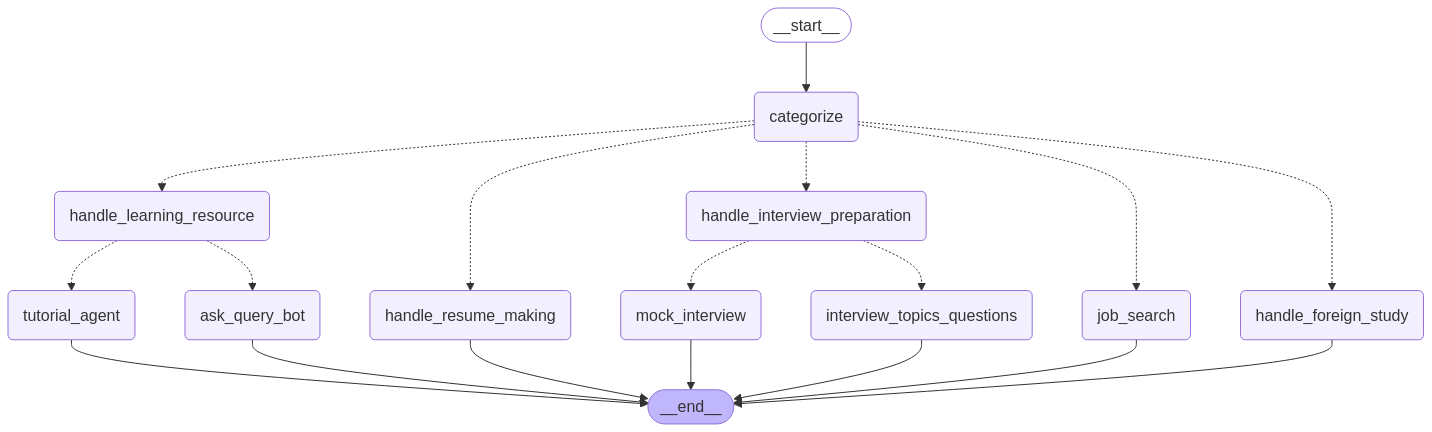

In [181]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

In [182]:
def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query,"agent_scratchpad": []})
    return {
        "category": results["category"],
        "response": results["response"]
    }

In [183]:
query = "I have gotten ielts score of 6.0, recommend me universities and subjects, location UK"
result = run_user_query(query)
result

Categorizing the customer query...
Category: Foreign Study
Many universities accept IELTS 6.0 for undergraduate and master's programs.


> Entering new AgentExecutor chain...

Invoking: `duckduckgo_results_json` with `{'query': 'universities accepting IELTS score 6.0'}`




RatelimitException: https://links.duckduckgo.com/d.js?q=universities+accepting+IELTS+score+6.0&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-313163756426964552025124236196141478242&bing_market=wt-WT&ex=-1 202 Ratelimit

In [ ]:
# query = "I want to learn Langchain and langgraph.With usage and concept. Also give coding example implementation for both.Create tutorial for this."
# result = run_user_query(query)
# result